In [13]:
%matplotlib inline
from construct import *
import numpy as np
import subprocess
import sys
import matplotlib.pyplot as plt
import pandas as pd
import struct
import re

# SSDV_PATH = 'ssdv'
SSDV_PATH = '/Users/dijkema/Desktop/dslwp/ssdv/ssdv/ssdv'

In [2]:
TMPrimaryHeader = BitStruct('transfer_frame_version_number' / BitsInteger(2),
                            'spacecraft_id' / BitsInteger(10),
                            'virtual_channel_id' / BitsInteger(3),
                            'ocf_flag' / Flag,
                            'master_channel_frame_count' / BitsInteger(8),
                            'virtual_channel_frame_count' / BitsInteger(8),
                            'first_header_pointer' / BitsInteger(8))

In [3]:
def format_range(missing_range):
    (beginstr, endstr) = missing_range
    begin = int(beginstr) + 1
    end = int(endstr) - 1
    if begin == end:
        return str(begin)
    else:
        return f"{begin}-{end}"

def format_missing_packets(ssdv_output):
    matches = re.findall("Gap detected between packets (.*) and (.*)", ssdv_output)
    return ",".join([format_range(missing_range) for missing_range in matches])

In [19]:
def seqnum(packet):
    return packet[1]*256 + packet[2]

def unwrap(seqnums):
    count = 0
    location = 0
    for j,x in enumerate(seqnums):
        if x >= 240:
            count += 1
            if count == 5:
                location = j
                break
        else:
            count = 0
    s = seqnums.copy().astype('int')
    s[location:][s[location:] < 230] += 256
    return s

def crc32(data, initial_value = 0):
    """Implementation taken from crc32() in ssdv.c"""
    crc = initial_value
    for d in data:
        x = (crc ^ d) & 0xFF
        for _ in range(8):
            if x & 1:
                x = (x >> 1) ^ 0xEDB88320
            else:
                x >>= 1
        crc = (crc >> 8) ^ x
    return crc ^ 0xFFFFFFFF

def check_ssdv_crc(frame):
    return crc32(frame[5:-4], 0x4EE4FDE1) == struct.unpack('>I', frame[-4:])[0]

def process_ssdv_frames(frames, output_path):
    missing_packets = {}
    x = np.frombuffer(bytes().join(frames), dtype = 'uint8').reshape((-1,223))[:,5:]
    seq = unwrap(x[:,0])
    ids = set(seq)
    for i in ids:
        l = list(x[seq==i,:])
        l.sort(key=seqnum)
        ssdv = '{}_{:03d}.ssdv'.format(output_path, i)
        jpeg = '{}_{:03d}.jpg'.format(output_path, i)
        np.array(l).tofile(ssdv)
        ssdv_output = subprocess.run([SSDV_PATH, '-d', '-D', ssdv, jpeg],
                                     stderr=subprocess.PIPE)
        missing_packets[i] = format_missing_packets(
            ssdv_output.stderr.decode('utf-8'))
    return missing_packets

In [7]:
frames = pd.read_csv('/Users/dijkema/Desktop/dslwp/dslwp-data/raw_frame.csv')
frames['raw_data'] = frames['raw_data'].apply(bytes().fromhex)
frames['is_ssdv'] = [TMPrimaryHeader.parse(frame).virtual_channel_id == 1 \
                     and check_ssdv_crc(frame) for frame in frames['raw_data']]

In [11]:
frames = frames[frames['remark']!="replay"]

In [20]:
missing_packets = process_ssdv_frames(frames[frames['is_ssdv']]['raw_data'].values,
                                      'output/img')

In [43]:
image_df = pd.DataFrame.from_dict(missing_packets, orient='index', columns=['missing_packets'])

In [47]:
def to_numpy_array(byteslist):
    return np.frombuffer(bytes().join(byteslist), dtype='uint8').reshape((-1,223))

In [48]:
frames['imageID'] = -1

/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
frames.loc[frames['is_ssdv'], 'imageID'] = \
    unwrap(to_numpy_array(frames[frames['is_ssdv']]['raw_data'].values)[:,5])

/anaconda/envs/school19/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


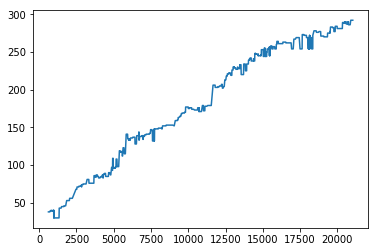

In [50]:
plt.plot(frames[frames['is_ssdv']]['imageID']);

In [59]:
image_df['contributors'] = ''
for imageID in range(300):
    imageframes = frames[frames['imageID']==imageID]
    if len(imageframes) > 0:
        contributors = np.unique(frames[frames['imageID']==imageID]['proxy_nickname'].values)
        image_df.loc[imageID, "contributors"] = ", ".join(contributors)

In [66]:
image_df["last_receive"] = frames[frames['is_ssdv']].groupby('imageID')['proxy_receive_time'].max()
image_df["first_receive"] = frames[frames['is_ssdv']].groupby('imageID')['proxy_receive_time'].min()

In [68]:
image_df.to_csv("temp.csv")